In [1]:
import pandas as pd
import pandas as pd
import seaborn as sns
import math
import re
import warnings
import missingno as msno
import os
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import List


warnings.filterwarnings("ignore")

2023-08-27 22:54:05.989044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 22:54:06.060752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 22:54:07.350626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1) Get data

In [2]:
def read_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read and import train and test data from CSV files.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the train and test data DataFrames.
    """
    train_data = pd.read_csv("./data/train.csv")
    print("Train data imported successfully!!")
    print("-"*50)
    test_data = pd.read_csv("./data/test.csv")
    print("Test data imported successfully!!")
    return train_data , test_data

raw_train_data , raw_test_data = read_data()

Train data imported successfully!!
--------------------------------------------------
Test data imported successfully!!


# 2) Exploratory data analysis & preprocessing:

In [3]:
raw_train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
raw_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2.1) Feature Engineering

Binary encode gender (male & female → 1 & 0)

In [5]:
# merging train and test data into one big dataframe
raw_all_data = pd.concat([raw_train_data , raw_test_data])

all_data_gender_binary_encoded = raw_all_data.copy()
all_data_gender_binary_encoded['Sex'] = raw_all_data['Sex'].replace({'male': 1, 'female': 0})

### 2.1.1) Normalizing features

In [6]:
# Define scaler to set values to mean 0 and std. dev. = 1
scaler = StandardScaler()

normalize_columns = [ 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare' ]
all_data_normalized = pd.DataFrame(scaler.fit_transform(all_data_gender_binary_encoded[normalize_columns]), columns = normalize_columns)

all_data_gender_binary_encoded.reset_index(drop=True, inplace=True)
all_data_normalized['Name'] = all_data_gender_binary_encoded['Name']
all_data_normalized['Ticket'] = all_data_gender_binary_encoded['Ticket']
all_data_normalized['Cabin'] = all_data_gender_binary_encoded['Cabin']
all_data_normalized['Embarked'] = all_data_gender_binary_encoded['Embarked']

### 2.1.2) Create Titles feature

In [7]:
def create_titles(name: str) -> str:
    """
    Extract and map titles from names.

    Args:
        name (str): The name containing a title.

    Returns:
        str: The mapped title.
    """
    name_regex_pattern = "(.*?)\,\s([^.]*)\.\s([^(]*)(\(([^\"]*)\))?"
    actual_title = re.search(name_regex_pattern, name).group(2)
    
    title_mapping = {
        "Ms": "Mrs",
        "Mlle": "Miss",
        "Mme": "Mrs",
        "Major": "Militar",
        "Col": "Militar",
        "Capt": "Militar",
        "the Countess": "Noble",
        "Lady": "Noble",
        "Sir": "Noble",
        "Don": "Noble",
        "Dona": "Noble",
        "Jonkheer": "Noble",
    }
    
    return title_mapping.get(actual_title, actual_title)

# Assuming all_data_normalized is a DataFrame
all_data_with_titles = all_data_normalized.copy()

# Extract the titles from the 'Name' column
all_data_with_titles['Titles'] = all_data_with_titles['Name'].apply(create_titles)


In [8]:
print(all_data_with_titles['Titles'].value_counts())

# One-hot encode the "Titles" column
all_data_with_titles_one_hot_encoded = pd.get_dummies(all_data_with_titles, columns=['Titles'])

Mr         757
Miss       262
Mrs        200
Master      61
Rev          8
Dr           8
Militar      7
Noble        6
Name: Titles, dtype: int64


## 2.2) Discovering & Imputing null data

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64


<AxesSubplot:>

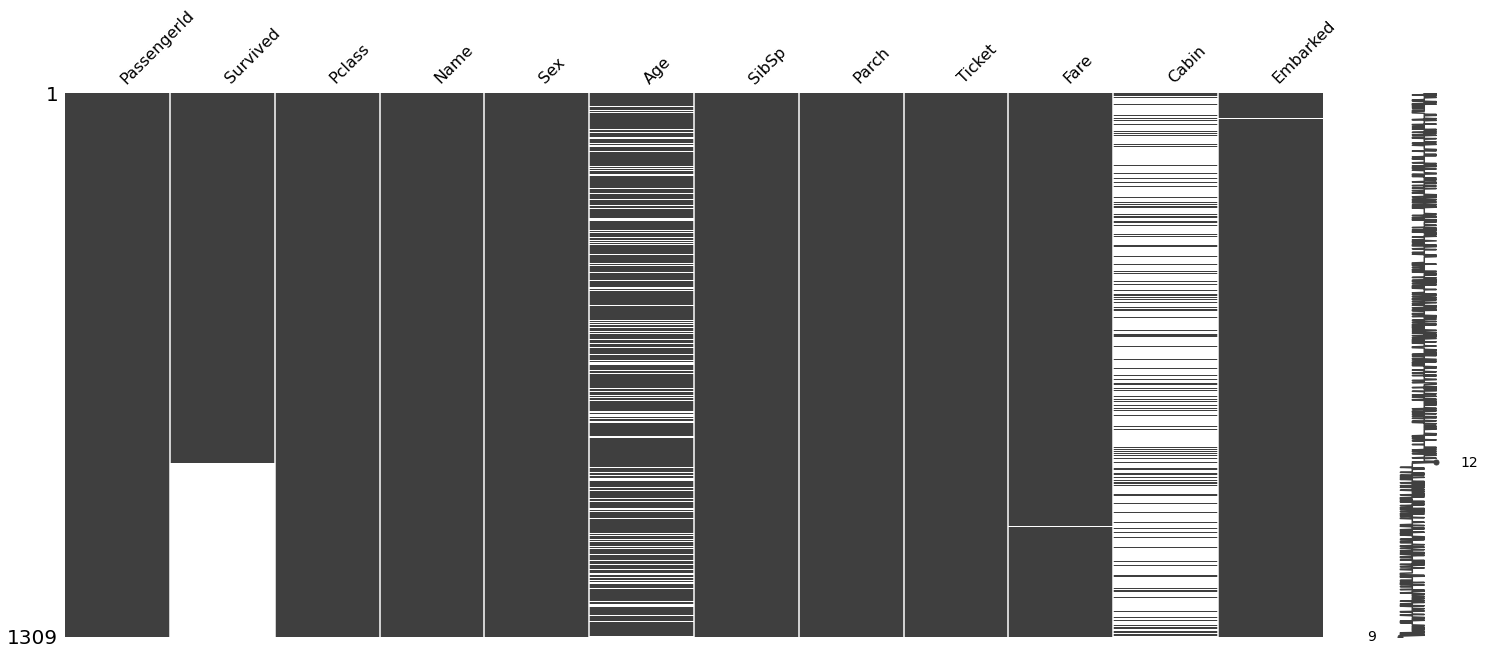

In [9]:
print(raw_all_data.isnull().mean()*100)

msno.matrix(raw_all_data)

### 2.2.1) Impute Embarked (manually)

Embarked is a categorial feature ("Q", "S", "C") with two missing values, so we can't really use it (as far as i know) on KNN, like we did below with Fare, so we're just going to do a simple approach and impute it with the most common value it has. 

S    914
C    270
Q    123
Name: Embarked, dtype: int64


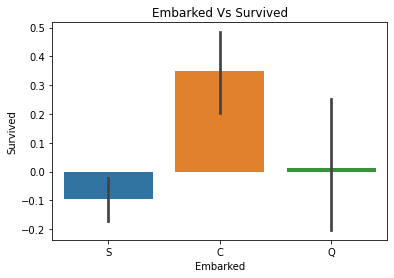

In [10]:
def bar_plot(data: pd.DataFrame, feature: str, target: str = "Survived"):
    """
    Create a bar plot to visualize the relationship between a categorical feature and a target variable.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        feature (str): The categorical feature to plot.
        target (str, optional): The target variable. Defaults to "Survived".
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(data=data, x=feature, y=target).set_title(f"{feature} Vs {target}")
    plt.show()

# Example usage:
# Assuming all_data_with_titles_one_hot_encoded is your DataFrame
print(all_data_with_titles_one_hot_encoded['Embarked'].value_counts())
bar_plot(all_data_with_titles_one_hot_encoded, "Embarked")


In [11]:
all_data_with_embarked_imputed = all_data_with_titles_one_hot_encoded.copy()
all_data_with_embarked_imputed["Embarked"] = all_data_with_embarked_imputed['Embarked'].fillna('S')
all_data_with_embarked_imputed["Embarked"].isnull().any()

False

### 2.2.2) Impute Fare (with KNN)

In [12]:
#One-hot encoding Embarked
all_data_with_embarked_one_hot_encoded = pd.get_dummies(all_data_with_embarked_imputed, columns=['Embarked'])
print(all_data_with_embarked_one_hot_encoded.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Name',
       'Ticket', 'Cabin', 'Titles_Dr', 'Titles_Master', 'Titles_Militar',
       'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Noble', 'Titles_Rev',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [13]:
all_data_with_fare_imputed = all_data_with_embarked_one_hot_encoded.copy()
# Define the features and target variables
features = ['Fare', 'SibSp', 'Parch', 'Pclass', 'Titles_Militar', 'Titles_Dr', 'Titles_Noble',
            'Titles_Master', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Rev', 'Embarked_C',
            'Embarked_Q', 'Embarked_S']

#Define a subset of the dataset (text features don't work with KNN)
data_knn = all_data_with_fare_imputed.filter(features, axis=1).copy()
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Define KNN imputer and fill missing values
tdx_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_knn), columns=data_knn.columns)

all_data_with_fare_imputed['Fare'] = tdx_knn_imputed['Fare']
all_data_with_fare_imputed["Fare"].isnull().any()

False

### 2.2.3) Impute Age (with random forest regressor)

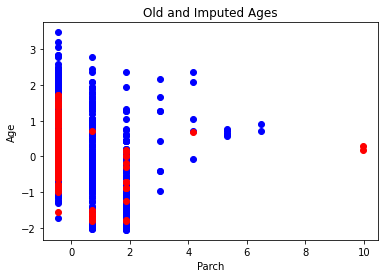

In [14]:
#Define a subset of the dataset (text features don't work with KNN)
from sklearn.ensemble import RandomForestRegressor
import numpy as np

all_data_with_age_imputed = all_data_with_fare_imputed.copy()
# data_knn = all_data.filter(['Fare','Age','SibSp','Parch', 'Pclass', 'Titles'], axis=1).copy()
# knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Define scaler to set values between 0 and 1
scaler = StandardScaler()

# Split the data into training and test sets
train_age_imputation_data = all_data_with_age_imputed[~all_data_with_age_imputed['Age'].isnull()]
test_age_imputation_data = all_data_with_age_imputed[all_data_with_age_imputed['Age'].isnull()]

# Define the features and target variables
features = ['Fare', 'SibSp', 'Parch', 'Pclass', 'Titles_Militar', 'Titles_Dr', 'Titles_Noble',
            'Titles_Master', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Rev', 'Embarked_C',
            'Embarked_Q', 'Embarked_S']
target = 'Age'

# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(train_age_imputation_data[features], train_age_imputation_data[target])

data_imputed = test_age_imputation_data.copy()
# Use the model to predict missing Age values in the test set
predicted_ages = model.predict(test_age_imputation_data[features])

# Fill in the missing Age values with the predicted values
all_data_with_age_imputed.loc[all_data_with_age_imputed['Age'].isnull(), 'Age'] = predicted_ages


# Plot the old ages in blue
plt.scatter(train_age_imputation_data['Parch'], train_age_imputation_data['Age'], color='blue')

# Plot the newly imputed ages in red
plt.scatter(test_age_imputation_data['Parch'], predicted_ages, color='red')

# Add axis labels and a title
plt.xlabel('Parch')
plt.ylabel('Age')
plt.title('Old and Imputed Ages')

# Show the plot
plt.show()


In [15]:
all_data_with_age_imputed["Age"].isnull().any()

False

## 2.3) Feature selection (Dropping useless columns)

In [16]:
all_data_processed = all_data_with_age_imputed.copy()
all_data_processed.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)
print(all_data_processed.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Titles_Dr', 'Titles_Master', 'Titles_Militar', 'Titles_Miss',
       'Titles_Mr', 'Titles_Mrs', 'Titles_Noble', 'Titles_Rev', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


## 2.4) Split data for training

In [17]:
train_data_processed = all_data_processed[all_data_processed['Survived'].notnull()]

X = train_data_processed.iloc[:, 1:]
y = train_data_processed.iloc[:, 0].astype(int)

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2)

X_test = all_data_processed[all_data_processed['Survived'].isnull()]
X_test.drop(['Survived'], axis=1, inplace=True)

print(X.shape)
print(y.shape)
assert((X.columns == X_test.columns).all())

X_test.head()
y_train.info()

(891, 17)
(891,)
<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 130 to 577
Series name: Survived
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


# 3) Use predictive model

## 3.1) Create the model

In [18]:
# Create neural network

input_shape = (17,)
num_classes = 1
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        # keras.layers.Dropout(0.1),
        keras.layers.Dense(30, activation="relu", activity_regularizer=keras.regularizers.l2(0.1)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(num_classes, activation="sigmoid"),
    ]
)

learning_rate = 0.005
# opt = keras.optimizers.SGD(learning_rate=learning_rate)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model.
model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                540       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 571 (2.23 KB)
Trainable params: 571 (2.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## 3.2) Train model

In [19]:
EPOCHS = 200
INITIAL_BATCH_SIZE = 256
LEARNING_RATE = 0.01

def scheduler(epoch: int) -> float:
    """
    Learning rate scheduler function.

    This function adjusts the learning rate during training using a schedule.

    Args:
        epoch (int): The current epoch number.

    Returns:
        float: The learning rate for the current epoch.
    """
    if epoch <= 100:
        return LEARNING_RATE
    else:
        return LEARNING_RATE / math.sqrt(epoch - 100)

# Create a learning rate scheduler callback
learning_rate_callback = keras.callbacks.LearningRateScheduler(scheduler)

# Train the model with different batch sizes
batch_sizes = [64, 64, 128, 256]

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    results = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_data=(X_cv, y_cv),
        verbose=0,
        callbacks=[learning_rate_callback]
    )


Training with batch size: 64
Training with batch size: 64
Training with batch size: 128
Training with batch size: 256


# 4) Model evaluation

6/6 [==============================] - 0s 2ms/step


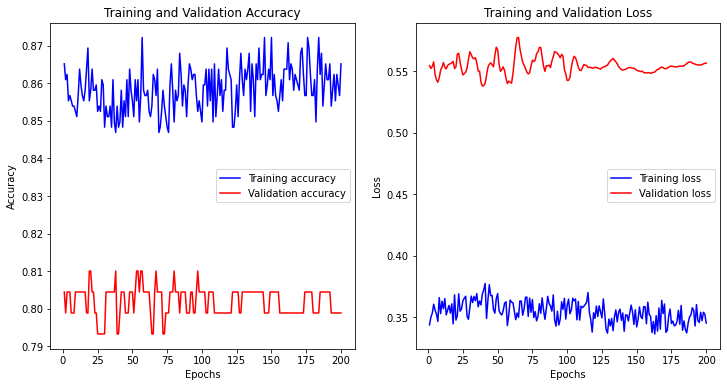

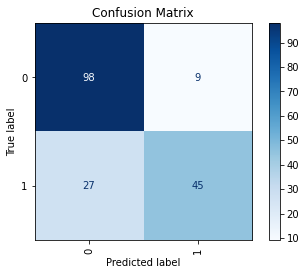

In [20]:
def plot_training_history(results: keras.callbacks.History):
    """
    Plot training and validation accuracy/loss over epochs.

    Args:
        results (keras.callbacks.History): History object containing training history.

    Returns:
        None
    """
    acc: List[float] = results.history['accuracy']
    val_acc: List[float] = results.history['val_accuracy']
    loss: List[float] = results.history['loss']
    val_loss: List[float] = results.history['val_loss']
    epochs: List[int] = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_confusion_matrix(y_true: List[int], y_pred: List[int]):
    """
    Display a confusion matrix plot.

    Args:
        y_true (List[int]): True labels.
        y_pred (List[int]): Predicted labels.

    Returns:
        None
    """
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    display.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

# one-hot-encoding y set
y_cv_prediction = model.predict(X_cv)
y_cv_prediction_rounded = [round(x) for arr in y_cv_prediction for x in arr]

plot_training_history(results)
plot_confusion_matrix(y_cv, y_cv_prediction_rounded)

Create .csv file with predictions

In [21]:
y_test_prediction = model.predict(X_test)
y_test_prediction_rounded = pd.Series([round(x) for arr in y_test_prediction for x in arr], name='Survived')

test_ids = pd.Series(raw_test_data.iloc[:, 0]) # get only the ids from the test dataset
result=pd.concat([test_ids, y_test_prediction_rounded],axis=1)
result.to_csv('./solutions/kaggle_titanic.csv',index=False)


14/14 [==============================] - 0s 2ms/step
